# Exploratory Data Analysis (EDA)
This notebook explores Brent crude oil prices (2012-2022) with descriptive statistics, missing data checks, visualizations, seasonality, outliers, and stationarity tests.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss

sns.set(style="whitegrid")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Load data
df = pd.read_csv("../data/raw/brent_prices.csv")

# Clean and standardize columns
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True, errors="coerce")
df = df.dropna(subset=["Date"]).sort_values("Date")

price_col = None
for col in ["Price", "Brent", "Brent_Price", "Close", "Value"]:
    if col in df.columns:
        price_col = col
        break
if price_col is None:
    raise ValueError("No price column found. Expected one of: Price, Brent, Brent_Price, Close, Value")

df = df[["Date", price_col]].rename(columns={price_col: "Price"}).set_index("Date")

# Focus on 2012-2022 window
df_recent = df.loc["2012-01-01":"2022-09-30"].copy()

df_recent.head()

C:\Users\hp\AppData\Local\Temp\ipykernel_5392\812665398.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"], dayfirst=True, errors="coerce")


,Price
Date,
2012-01-03,111.12
2012-01-04,113.37
2012-01-05,113.59
2012-01-06,111.96
2012-01-09,111.07


In [3]:
# Basic overview
print(df_recent.info())
display(df_recent.describe())

# Check duplicate dates
dup_dates = df_recent.index.duplicated().sum()
print(f"Duplicate dates: {dup_dates}")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2729 entries, 2012-01-03 to 2022-09-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   2729 non-null   float64
dtypes: float64(1)
memory usage: 42.6 KB
None


,Price
count,2729.000000
mean,73.917149
std,26.732861
min,9.120000
25%,52.180000
50%,67.030000
75%,103.450000
max,133.180000


Duplicate dates: 0


In [4]:
# Missing data profile
missing_counts = df_recent.isna().sum()
missing_pct = (missing_counts / len(df_recent) * 100).round(2)
missing_df = pd.DataFrame({"missing": missing_counts, "missing_pct": missing_pct})
display(missing_df)

,missing,missing_pct
Price,0,0.0


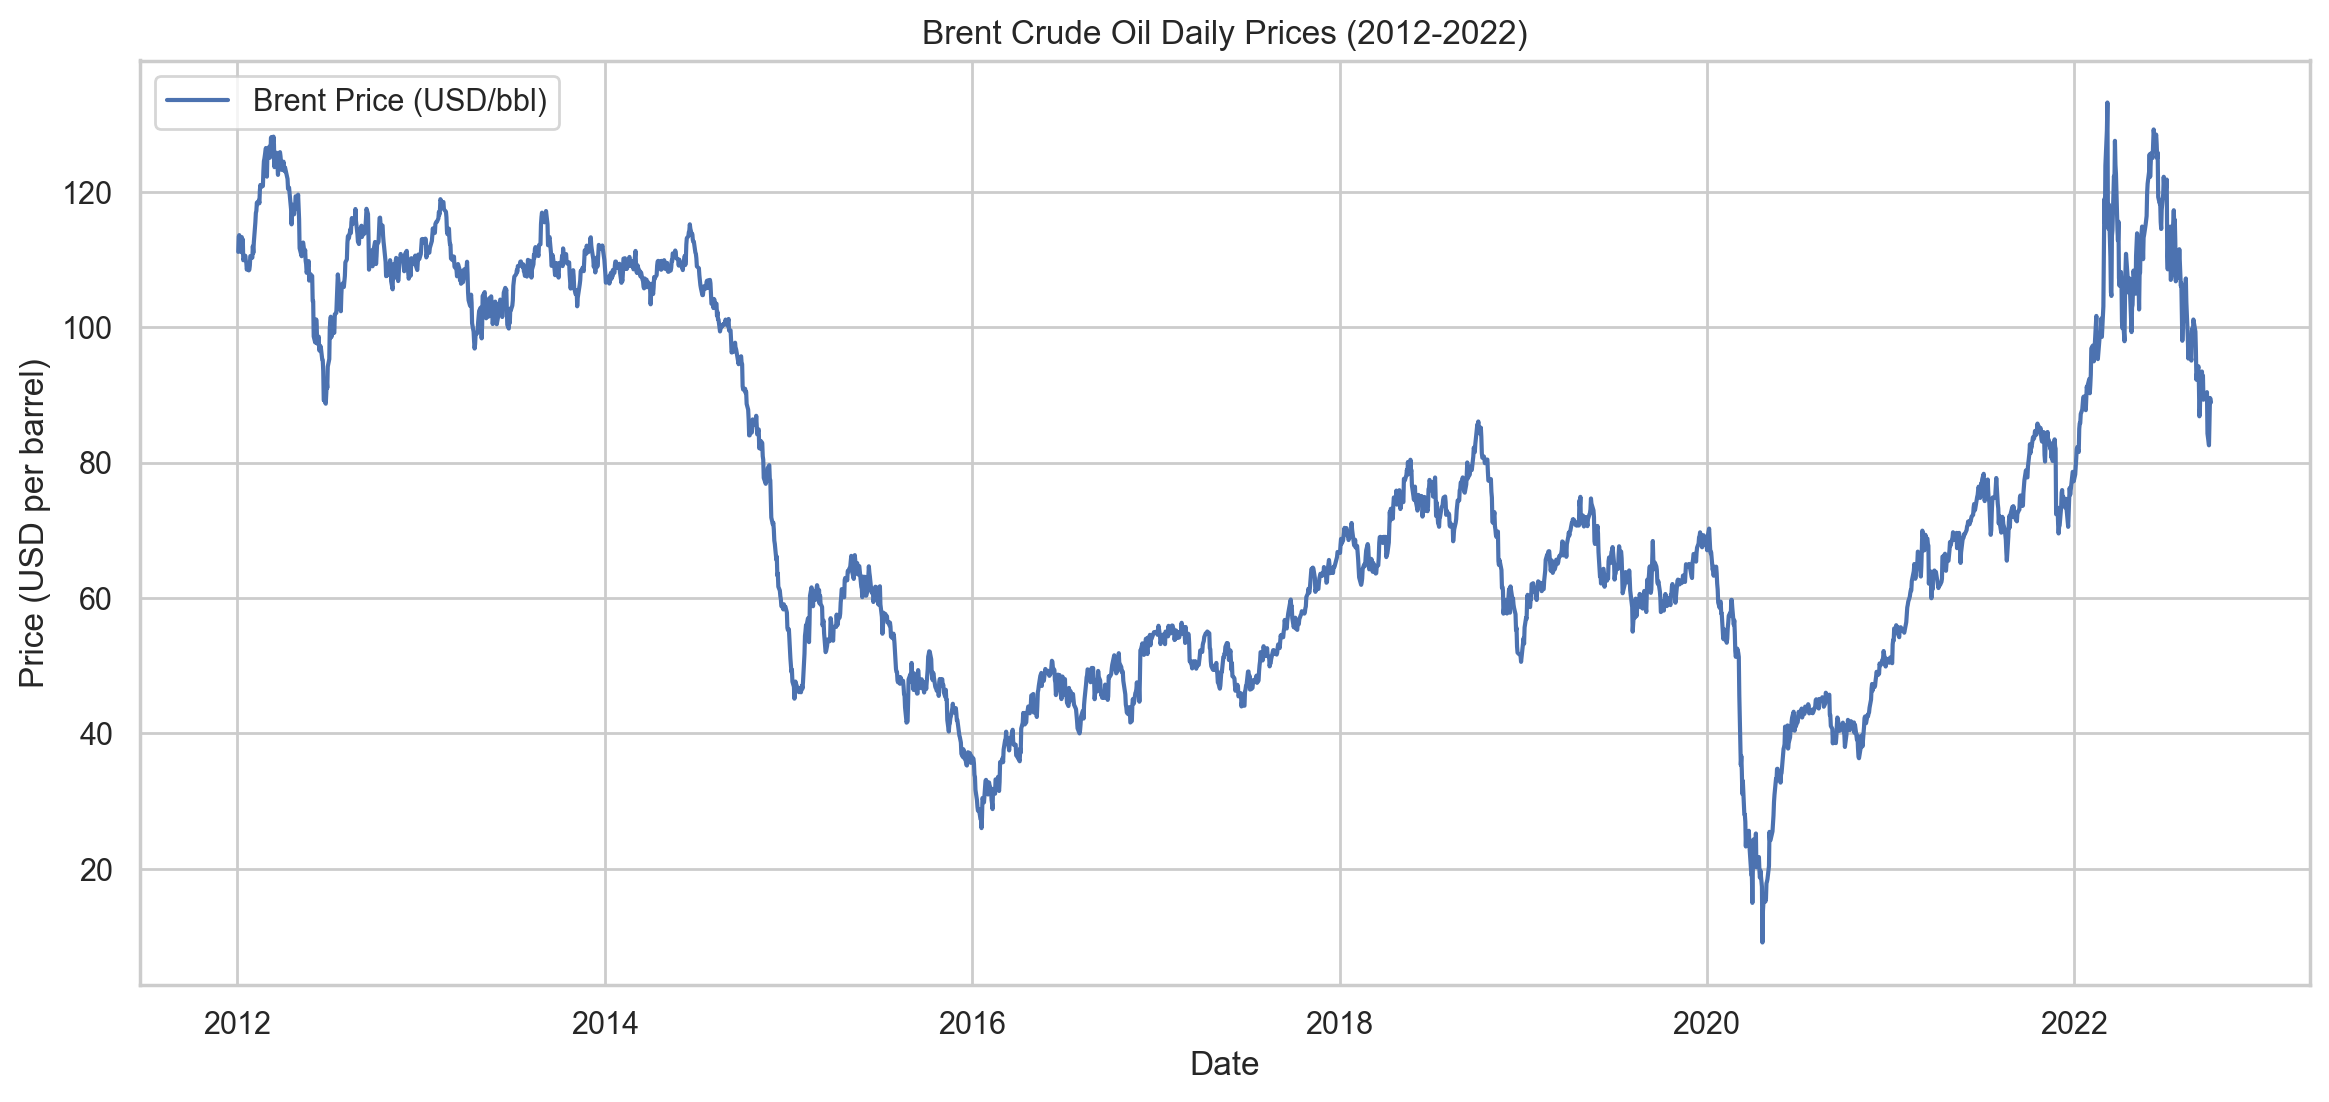

In [5]:
# Price series
plt.figure(figsize=(14, 6))
plt.plot(df_recent.index, df_recent["Price"], label="Brent Price (USD/bbl)")
plt.title("Brent Crude Oil Daily Prices (2012-2022)")
plt.xlabel("Date")
plt.ylabel("Price (USD per barrel)")
plt.legend()
plt.show()

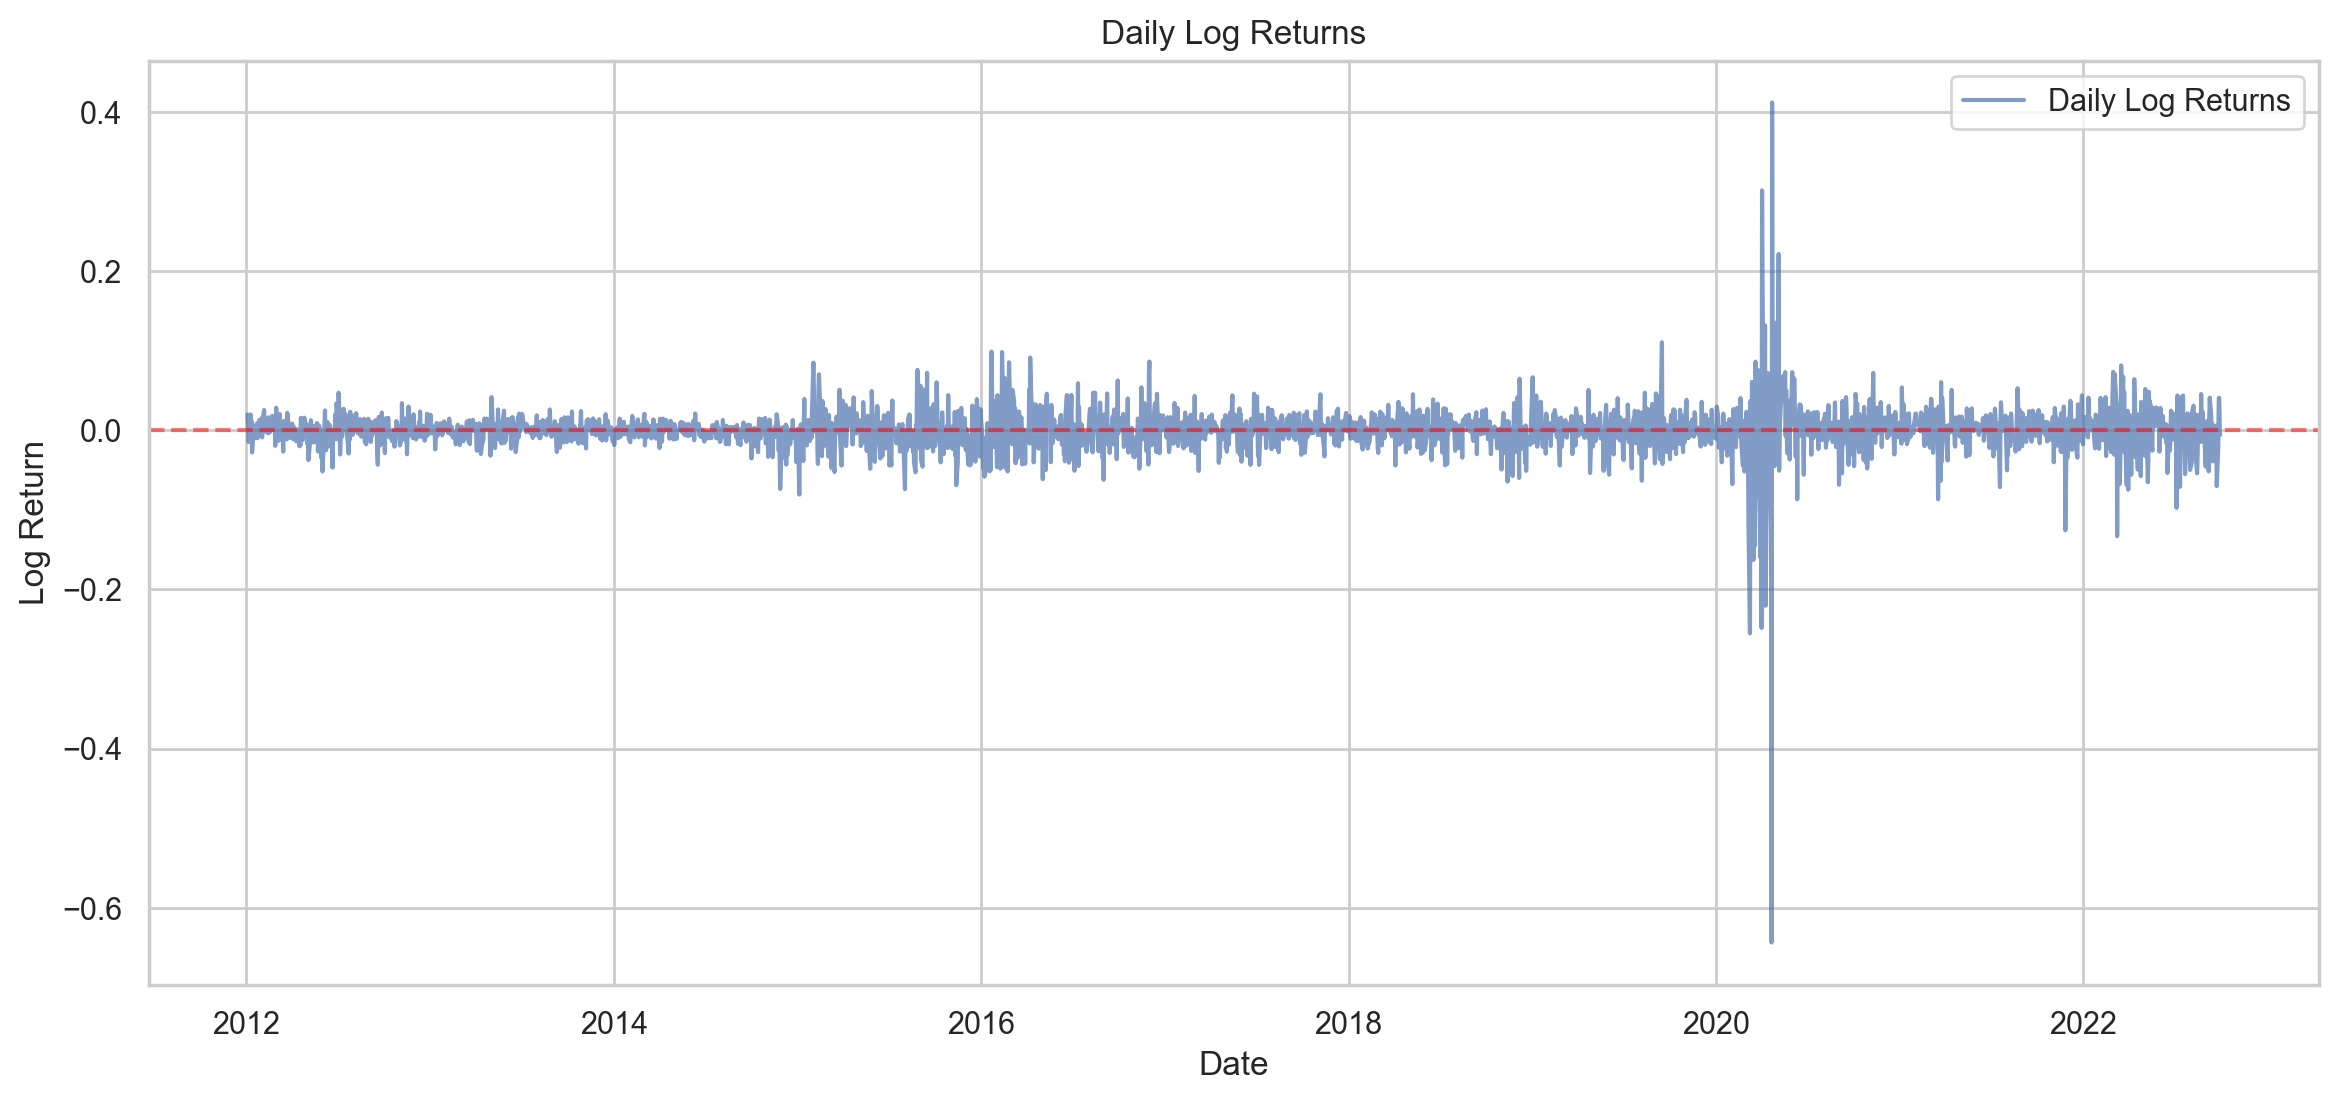

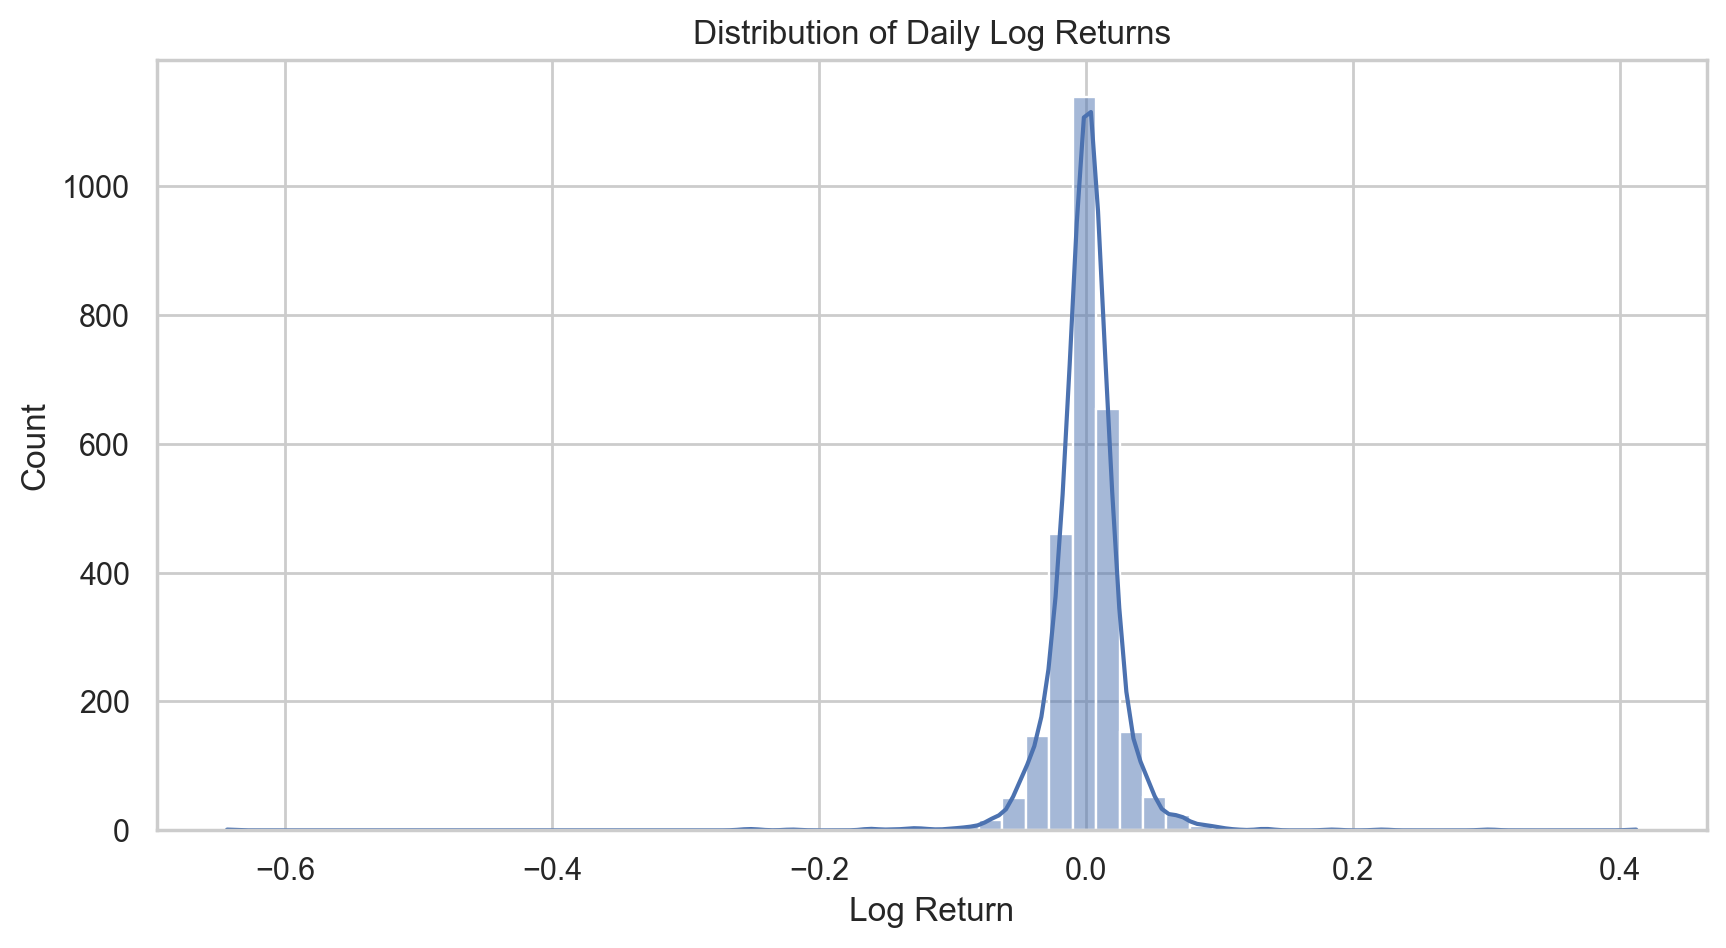

In [6]:
# Log returns
df_recent["LogPrice"] = np.log(df_recent["Price"])
df_recent["LogReturn"] = df_recent["LogPrice"].diff()

plt.figure(figsize=(14, 6))
plt.plot(df_recent.index[1:], df_recent["LogReturn"].dropna(), alpha=0.7, label="Daily Log Returns")
plt.axhline(0, color="red", linestyle="--", alpha=0.5)
plt.title("Daily Log Returns")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(df_recent["LogReturn"].dropna(), bins=60, kde=True)
plt.title("Distribution of Daily Log Returns")
plt.xlabel("Log Return")
plt.ylabel("Count")
plt.show()

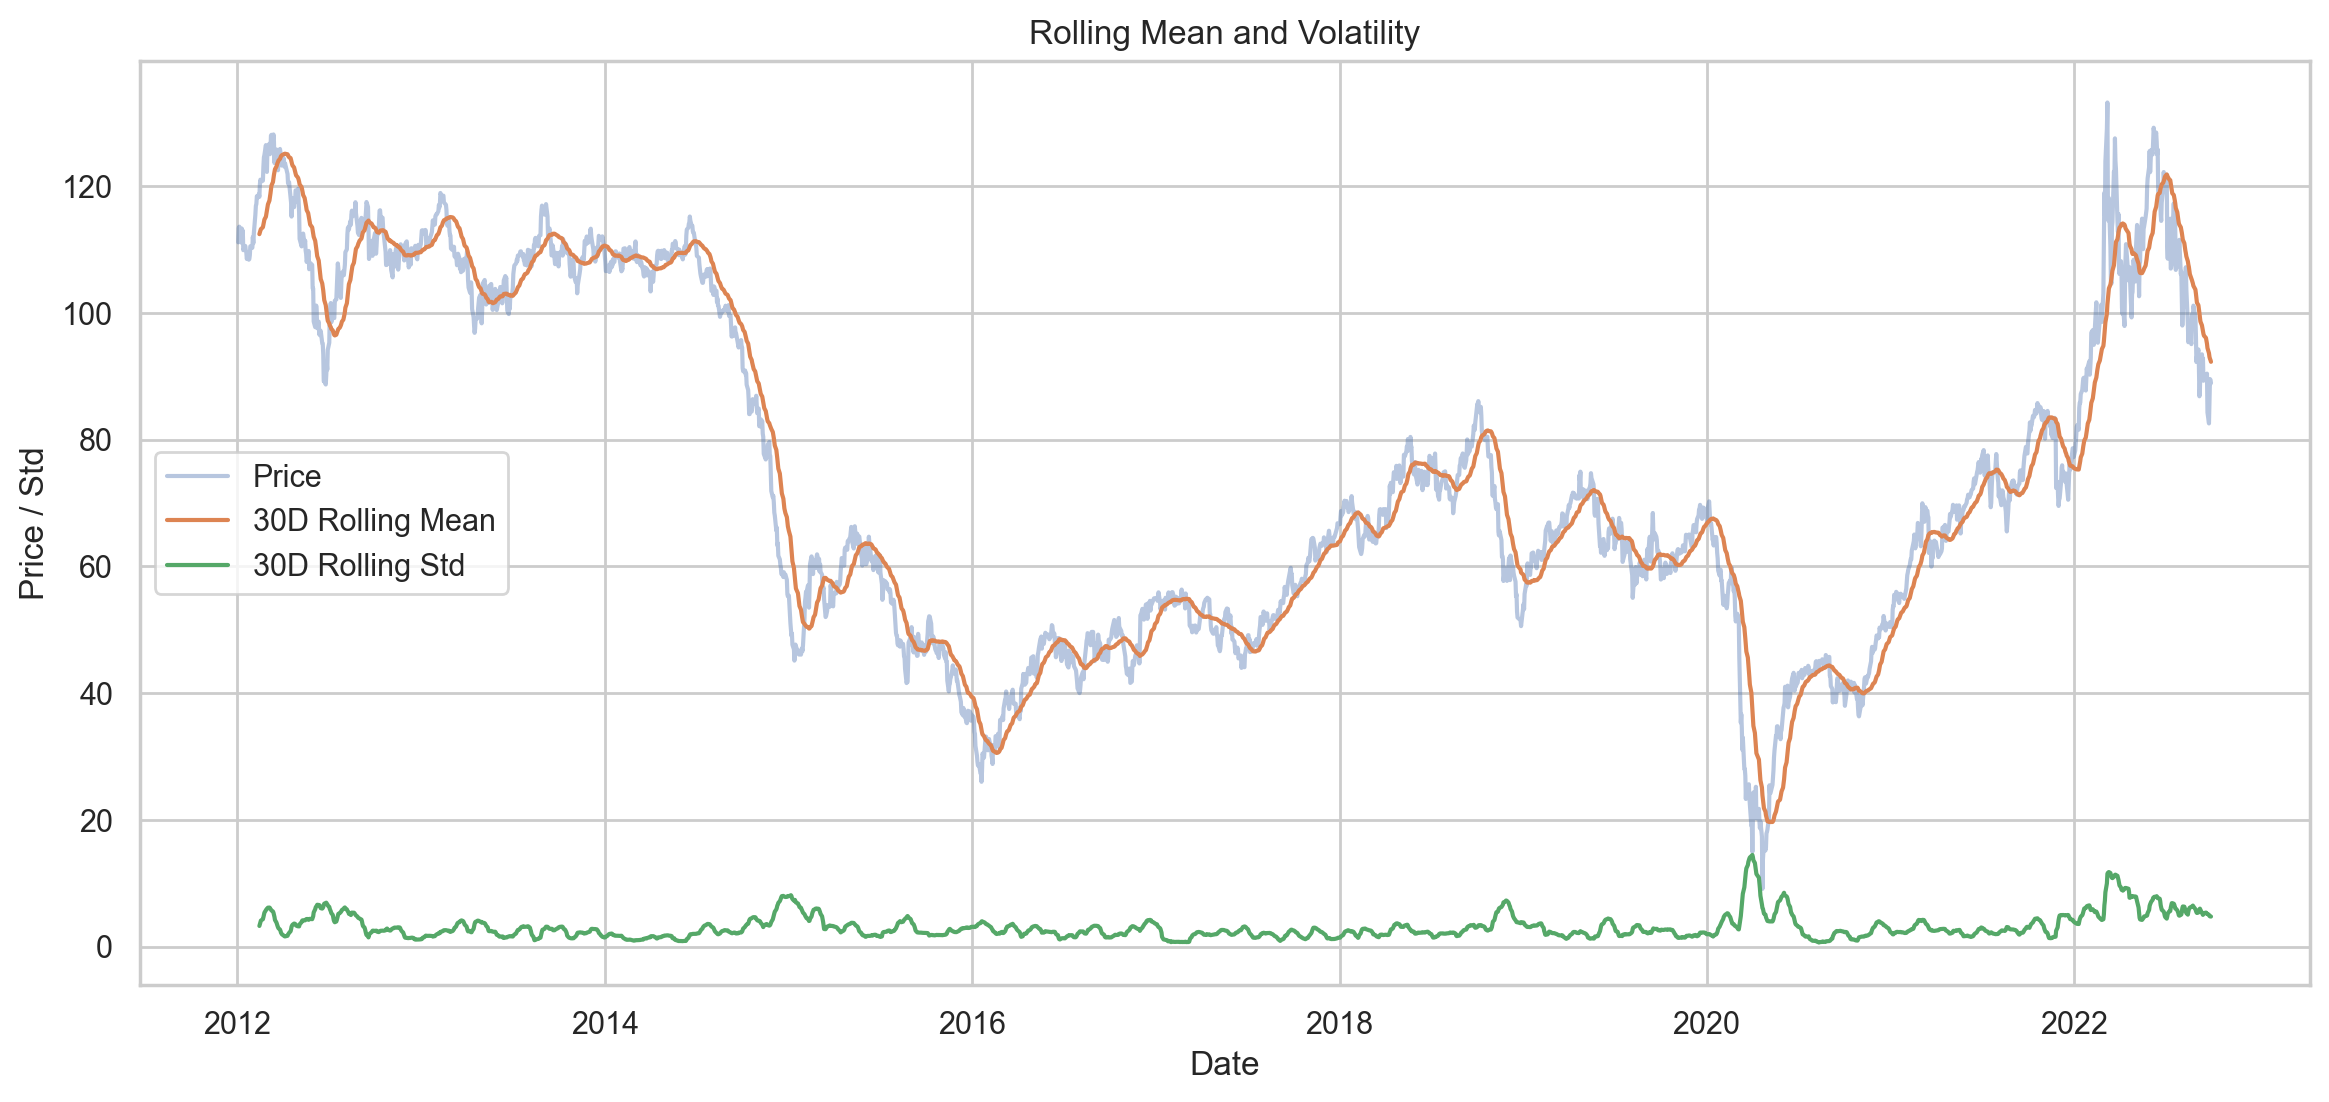

In [7]:
# Rolling mean and volatility
window = 30
rolling_mean = df_recent["Price"].rolling(window).mean()
rolling_std = df_recent["Price"].rolling(window).std()

plt.figure(figsize=(14, 6))
plt.plot(df_recent.index, df_recent["Price"], alpha=0.4, label="Price")
plt.plot(df_recent.index, rolling_mean, label=f"{window}D Rolling Mean")
plt.plot(df_recent.index, rolling_std, label=f"{window}D Rolling Std")
plt.title("Rolling Mean and Volatility")
plt.xlabel("Date")
plt.ylabel("Price / Std")
plt.legend()
plt.show()

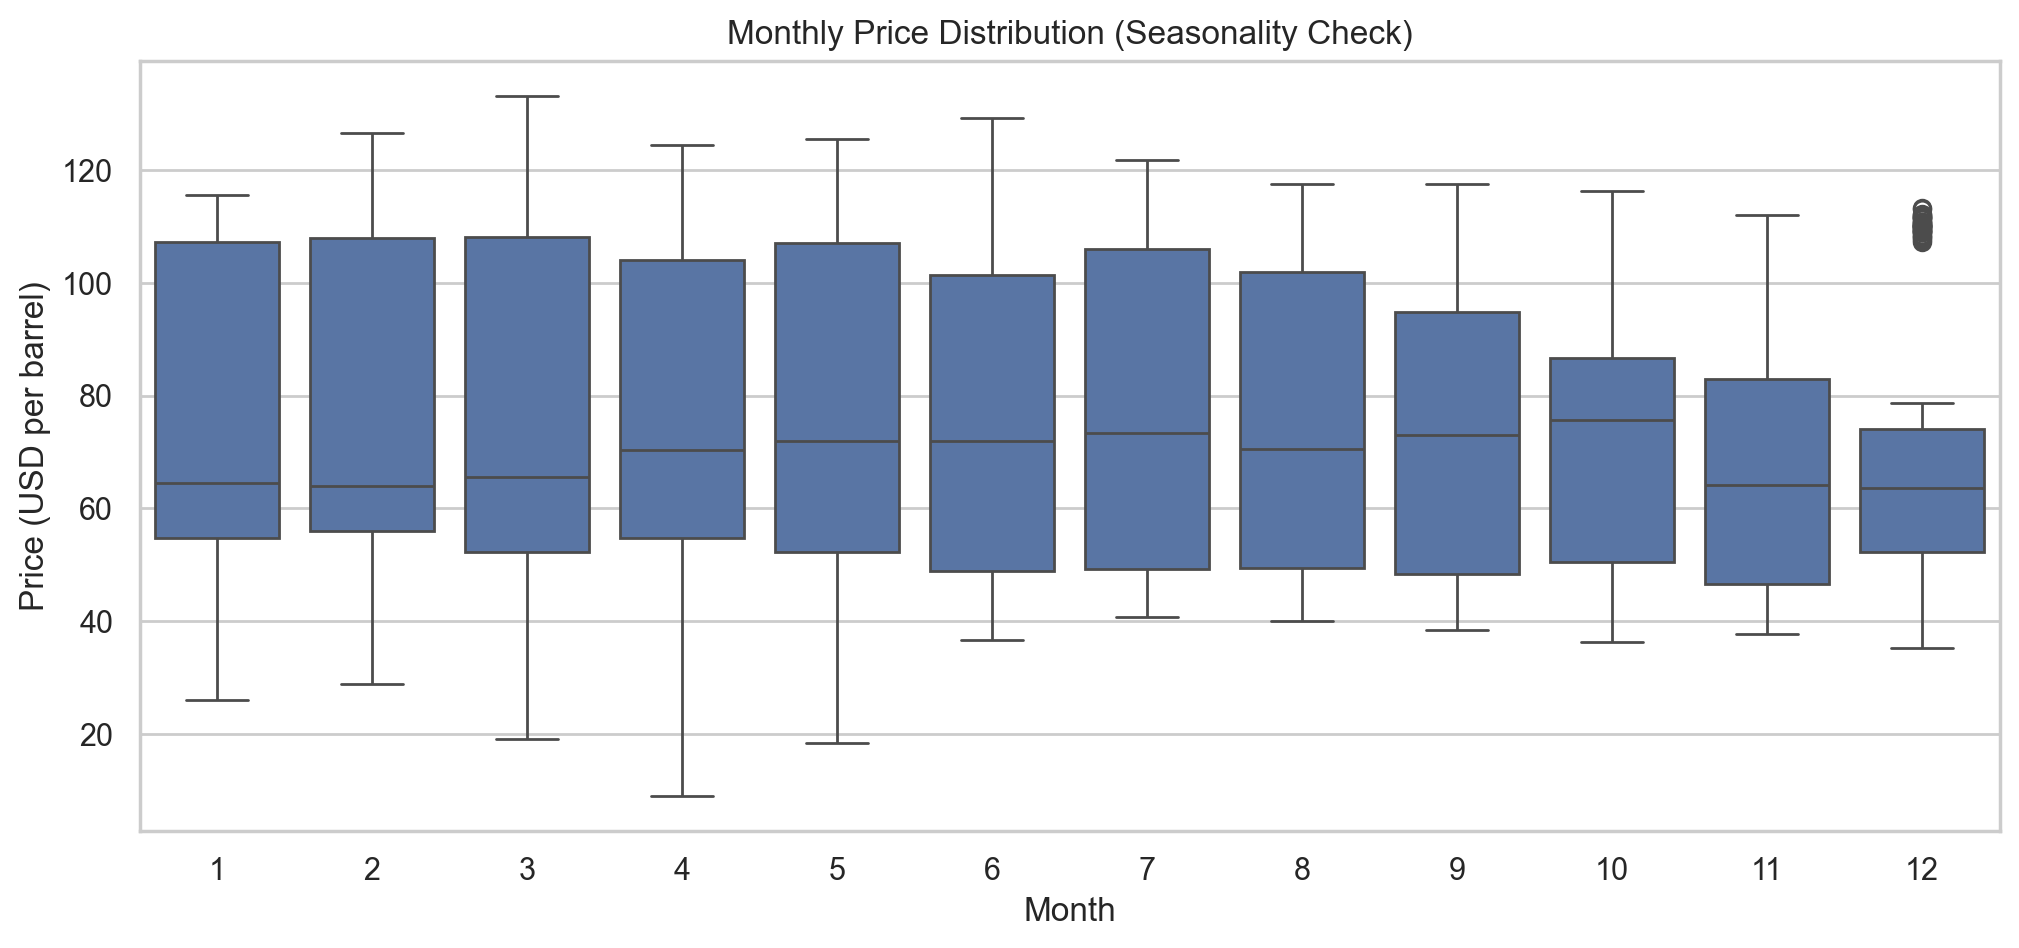

In [8]:
# Seasonality by month
df_recent["Month"] = df_recent.index.month
plt.figure(figsize=(12, 5))
sns.boxplot(x="Month", y="Price", data=df_recent.reset_index())
plt.title("Monthly Price Distribution (Seasonality Check)")
plt.xlabel("Month")
plt.ylabel("Price (USD per barrel)")
plt.show()

In [9]:
# Outlier checks (IQR and z-score)
price_series = df_recent["Price"].dropna()
q1, q3 = price_series.quantile([0.25, 0.75])
iqr = q3 - q1
lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
iqr_outliers = price_series[(price_series < lower) | (price_series > upper)]

z_scores = (price_series - price_series.mean()) / price_series.std()
z_outliers = price_series[z_scores.abs() > 3]

print(f"IQR outliers: {len(iqr_outliers)}")
print(f"Z-score outliers (>3): {len(z_outliers)}")

display(iqr_outliers.head())

IQR outliers: 0
Z-score outliers (>3): 0


Series([], Name: Price, dtype: float64)

In [10]:
# Stationarity tests (ADF and KPSS)
def stationarity_tests(series, name):
    series = series.dropna()
    adf_stat, adf_p, *_ = adfuller(series, autolag="AIC")
    kpss_stat, kpss_p, *_ = kpss(series, regression="c", nlags="auto")
    print(f"{name}: ADF p-value={adf_p:.4f}, KPSS p-value={kpss_p:.4f}")

stationarity_tests(df_recent["Price"], "Price")
stationarity_tests(df_recent["LogReturn"], "LogReturn")

Price: ADF p-value=0.2642, KPSS p-value=0.0100
LogReturn: ADF p-value=0.0000, KPSS p-value=0.1000


C:\Users\hp\AppData\Local\Temp\ipykernel_5392\2950451136.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(series, regression="c", nlags="auto")
C:\Users\hp\AppData\Local\Temp\ipykernel_5392\2950451136.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(series, regression="c", nlags="auto")


## EDA Takeaways
- Expect structural breaks around 2014-2016, early 2020, and early 2022.
- Raw prices should look non-stationary; log returns closer to stationary.
- Volatility clustering is visible in log returns and rolling std.
- Outliers are meaningful market shocks rather than data errors.